In [1]:
import pickle
import cv2
from glob import glob 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pipeline as pl
from sklearn import datasets, linear_model
from scipy.optimize import least_squares
#import mkl
#mkl.get_cpu_clocks()
import copy
import sys
from tqdm import tqdm


import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip


In [2]:
# Prepare main data containers
path = {'calibration': './camera_cal/',
        'example': './examples/',
        'test': './test_images/'}
files      = {key:[] for key in path}
images     = {key:[] for key in path}
cal_images = {key:[] for key in path}

# Get filenames of all images
files['calibration'] = glob(path['calibration'] + 'calibration*.jpg')
files['example']     = glob(path['example'] + '*.jpg')
files['test']        = glob(path['test'] + '*.jpg')

# Load all images
for key in files:
    print("Load {} images...".format(key))
    for file in files[key]:
        images[key].append(mpimg.imread(file))
        
video_filename = '/home/timo/Documents/udacity/carnd1/CarND-Advanced-Lane-Lines/project_video.mp4'

Load calibration images...
Load example images...
Load test images...


In [3]:
images['project_video'] = []

video = VideoFileClip(video_filename)
cnt = 0
for frame in video.iter_frames(progress_bar=True):
    cnt += 1
    images['project_video'].append(frame)
    if cnt > 10:
        break

  0%|          | 0/1261 [00:00<?, ?it/s]


In [ ]:
# Get camera calibration parameters
camera_matrices, distortion_coefficients, singuar_values = pl.get_calibration_parameters(copy.deepcopy(images['calibration']), verbose=1)
mtx, dist = camera_matrices[-1,::], distortion_coefficients[-1]
# Calibrate all images
cal_images = {key: [] for key in images}
pl.calibrate_images(images, cal_images, mtx, dist, verbose=1)
print("Calibration done.")

In [ ]:
def dummy(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

result_output    = 'test_output.mp4'
clip1            = VideoFileClip(video_filename)
white_clip       = clip1.fl_image(dummy) #NOTE: this function expects color images!!
%time white_clip.write_videofile(result_output, audio=False)

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(18,18))
for ax, key in zip(axes.flatten(), images):
    ax.imshow(images[key][0])
plt.show()

In [ ]:
dst = cv2.undistort(images['project_video'][5], mtx, dist, None, mtx)

plt.imshow(dst)
plt.show()

## Calibrate Camera

### Analyse Calibration Results

In [ ]:
fig, axes = plt.subplots(3,1, figsize=(18,10))
fig.subplots_adjust(hspace=0.15, wspace=0.15)
axes[0].plot(distortion_coefficients)
axes[0].set_title("Distortion Coefficient")
axes[0].set_ylabel("Value of Distortion Coefficient")
axes[0].grid('on')

axes[1].plot(camera_matrices.reshape(-1, 9))
axes[1].set_title("Camera Matrix Elements")
axes[1].set_ylabel("Value of Camera Matrix Element")
axes[1].grid('on')

axes[2].plot(singuar_values[:,0])
axes[2].set_title("First Singular Value of Camera Matrix")
axes[2].set_ylabel("First Singl. Value of Cam. Matrix")
axes[2].grid('on')

plt.show()

### Compare Original and Undistorted Images

In [ ]:
nb_images = 3

fig, axes = plt.subplots(nb_images, 2, figsize=(18, (nb_images * 5)))
fig.subplots_adjust(hspace=0.15, wspace=0.15)
for i, org, cal in zip(range(0, nb_images), images['calibration'], cal_images['calibration']):
    axes[i,0].imshow(org)
    axes[i,1].imshow(cal)
axes[0,0].set_title('Original Images', fontsize=26)
axes[0,1].set_title('Undistorted Images', fontsize=26)
plt.show()

In [ ]:
#%matplotlib nbagg
img = cal_images['test'][0].copy()

pts = np.array([[256,670],[1056,670],[638,422],[638,422]], np.int32)
pts = np.array([[256,670],[1056,670],[685,450],[621,450]], np.int32)

pts = pts.reshape((-1,1,2))
cv2.polylines(img,[pts],True,(20,255,155),1)


plt.figure(figsize=(18, 12))
plt.imshow(img)
plt.show()

## Compute Perspective Transform

In [ ]:
key = 'project_video'
nb  = 0
img = images[key][nb].copy()
cal = cal_images[key][nb]

y1, y2 = 720.0, 450.0
x1, x2 = 80.0, 1200.0

dx = 500.0
dy = -25

src_rect = np.zeros((4, 2), dtype = "float32")
src_rect[0,:] = [x2-dx-20,y2] # right top
src_rect[1,:] = [x1+dx,y2] # right buttom
src_rect[2,:] = [x1,y1]
src_rect[3,:] = [x2,y1]

dst_rect = np.zeros((4, 2), dtype = "float32")
dst_rect[0,:] = [1180,100]
dst_rect[1,:] = [100,100]
dst_rect[2,:] = [100,620]
dst_rect[3,:] = [1180,620]

for c in src_rect:
    result = cv2.circle(img.copy(), tuple(c), 1, 0xFF, 4)
    
for d in dst_rect:
    result = cv2.circle(img.copy(), tuple(d), 1, 0x00, 10)
cv2.polylines(img, [src_rect.reshape(4,1,2).astype(int)], True, (20,255,155), 3)
cv2.polylines(img, [dst_rect.reshape(4,1,2).astype(int)], True, (255,0,0), 10)

binary_combined = pl.lane_detection(cal, verbose=0)

M = cv2.getPerspectiveTransform(src_rect, dst_rect)

# Compute the inverse perspective transform:
Minv = cv2.getPerspectiveTransform(dst_rect, src_rect)

# Warp an image using the perspective transform, M:
warped = cv2.warpPerspective(binary_combined, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
unwarped = cv2.warpPerspective(warped, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
# gray   = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)

plt.figure(figsize=(18, 12))
plt.imshow(img)
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(warped, 'gray')
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(unwarped, 'gray')
plt.show()
plt.figure(figsize=(20,20))
plt.imshow(255*unwarped+cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), 'gray')
plt.show()



## Undistort Camera Images

### Comparison of Original and Calibrated Image

In [ ]:
alpha = 0.5
overlay = cal.copy()
output = img.copy()
# Apply the overlay
result = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0, output)

fig, axes = plt.subplots(2,2, figsize=(18,11))
fig.subplots_adjust(hspace=0.15, wspace=0.25)

fontsize = 22

axes[0,0].imshow(img)
axes[0,0].set_title('Original Image', fontsize=fontsize)
axes[0,1].imshow(cal)
axes[0,1].set_title('Undistorted Image', fontsize=fontsize)
axes[1,0].imshow(result)
axes[1,0].set_title('Overlay of the Original and the Undistorted Image', fontsize=fontsize)
axes[1,1].imshow(img-cal)
axes[1,1].set_title('Difference Image: Original-Undistorted', fontsize=fontsize)

plt.show()

## Edge Detection

In [ ]:
# Plot the result
fig, axes = plt.subplots(2, 1, figsize=(14, 18))
#fig.tight_layout()
fontsize = 26
axes[0].imshow(img)
axes[0].set_title('Original Image', fontsize=fontsize)

axes[1].imshow(binary_combined, 'gray')
axes[1].set_title('Pipeline Result', fontsize=fontsize)

plt.show()

## Lane Fit 

In [ ]:
from scipy import ndimage
from moviepy.editor import VideoFileClip

def draw_lines_on_image(image):
    
    warped, M, Minv = warp_image(image)

    p_l, p_r = find_lines(warped)
    
    x  = np.arange(100,650,1)
    yl = p_l[0] * x**2 + p_l[1] * x + p_l[2] 
    yr = p_r[0] * x**2 + p_r[1] * x + p_r[2] 
    
    result = np.zeros_like(warped.T)
    X = x.astype(int)
    for y in (yl,yr):
        Y = y.astype(int)
        result[Y, X] = 1
    result = ndimage.rotate(result, 90)
    result_unwarped = cv2.warpPerspective(result.astype(float), Minv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_LINEAR)
    return result_unwarped




In [ ]:
image = images['project_video'][0]
binary_warped, M, Minv = warp_image(image)

left_fit, right_fit = find_lines(binary_warped)
plt.show()

In [ ]:
warped, _, _ = warp_image(images['project_video'][5])
print(warped.shape)
l,r = find_lines(warped)

plt.imshow(warped)
plt.show()


In [100]:
def find_lines(binary_warped, verbose=0):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[360:720,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if verbose==1:
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    # Create an image to draw on and an image to show the selection window
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    #out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    #out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
        # Timo 
    lane_window_left  = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    lane_window_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_window_pts   = np.hstack((lane_window_left, lane_window_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([lane_window_pts]), (0,0, 255))
    
    
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    if verbose==1:
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    left_curverad, right_curverad = calculate_curvature_radius(leftx=leftx, rightx=rightx, lefty=lefty, righty=righty)
    textfields = ("left: {:.2f} m".format(left_curverad), "right: {:.2f} m". format(right_curverad))
    textcoords = ((145, 700), (900, 700))
        
    
    return result, left_fit, right_fit, textfields, textcoords

In [101]:
class Lane():
    
    def __init__(self):
        
        self.left_fit = []
        self.right_fit = []
        
        self.linesearch_initialized = False
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [102]:
def get_birdseye_view_parameters(verbose=0):
    if verbose==1:
        print("Load birdseye view parameters...")
    y1, y2 = 720.0, 450.0
    x1, x2 = 80.0, 1200.0

    dx = 500.0
    dy = -25

    src_rect = np.zeros((4, 2), dtype = "float32")
    src_rect[0,:] = [x2-dx-20,y2] # right top
    src_rect[1,:] = [x1+dx,y2] # right buttom
    src_rect[2,:] = [x1,y1]
    src_rect[3,:] = [x2,y1]

    dst_rect = np.zeros((4, 2), dtype = "float32")
    dst_rect[0,:] = [1180,100]
    dst_rect[1,:] = [100,100]
    dst_rect[2,:] = [100,720]
    dst_rect[3,:] = [1180,720]

    M = cv2.getPerspectiveTransform(src_rect, dst_rect)

    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst_rect, src_rect)
    if verbose==1:
        print("Done.")
    return M, Minv

def get_final_calibration_parameters(calibration_images, verbose=0):
    if verbose==1:
        print("Load calibration view parameters...")
    
    camera_matrices, distortion_coefficients, singuar_values = pl.get_calibration_parameters((calibration_images), verbose=0)
    mtx, dist = camera_matrices[-1,::], distortion_coefficients[-1]
    if verbose==1:
        print("Done.")
    return mtx, dist

def undistort_image(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

def detect_edges(image):
    return pl.lane_detection(image, verbose=0)

def transform_to_birdseye_view(image, target_dim=(1280, 720)):
    return cv2.warpPerspective(image, M, target_dim, flags=cv2.INTER_LINEAR)

def transform_to_camera_view(image, target_dim=(1280, 720)):
    return cv2.warpPerspective(image, Minv, target_dim, flags=cv2.INTER_LINEAR)

def windowed_line_search(image, verbose=0):
    result, left_fit, right_fit,  textfields, textcoords = find_lines(image, verbose=verbose)
    return result, left_fit, right_fit, textfields, textcoords

def ancestor_line_search(image, left_fit, right_fit, verbose=0):
    binary_warped = image
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    
        # Timo 
    lane_window_left  = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    lane_window_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    lane_window_pts   = np.hstack((lane_window_left, lane_window_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([lane_window_pts]), (0,0, 255))

    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    if verbose==1:
        print("In ancestor line search: ", result.shape)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    left_curverad, right_curverad = calculate_curvature_radius(leftx=leftx, rightx=rightx, lefty=lefty, righty=righty)
    textfields = ("left: {:.2f} m".format(left_curverad), "right: {:.2f} m". format(right_curverad))
    textcoords = ((145, 700), (900, 700))
        
    return result, textfields, textcoords

def overlay(frame, line_image):
    
    result = cv2.addWeighted(frame.astype(float), 1, line_image.astype(float), 0.3, 0)
    return result.astype(np.uint8)

def calculate_curvature_radius(leftx, rightx, lefty, righty):
    y = np.max(righty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty * ymeter_per_pixel, leftx * xmeter_per_pixel, 2)
    right_fit_cr = np.polyfit(righty * ymeter_per_pixel, rightx * xmeter_per_pixel, 2)
    
    # Calculate the new radii of curvature
    A, B, C = left_fit_cr
    y = np.max(lefty)
    left_curverad = ((1 + (2*A*y*ymeter_per_pixel + B)**2)**1.5) / np.absolute(2*A)
    
    y = np.max(lefty)
    A, B, C = right_fit_cr
    right_curverad = ((1 + (2*A*y * ymeter_per_pixel + B)**2)**1.5) / np.absolute(2*A)
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    return left_curverad, right_curverad

def put_text_annotations(image, textfields, textcoords, font):
    color = (255,255,255)
    for textfield, coordinate in zip(textfields, textcoords):
        result = cv2.putText(image, textfield, coordinate, font, 1, color, 2, cv2.LINE_AA)
    return result

Load birdseye view parameters...
Done.
Load calibration view parameters...
Done.
Window search
Ancestor search
In ancestor line search:  (720, 1280, 3)


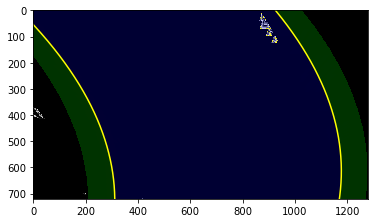

Ancestor search
In ancestor line search:  (720, 1280, 3)


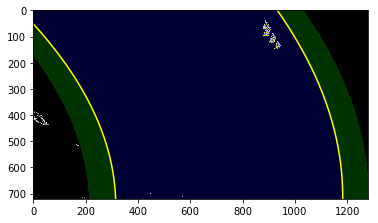

In [103]:
M, Minv = get_birdseye_view_parameters(verbose=1)
# Get camera calibration parameters
mtx, dist = get_final_calibration_parameters(calibration_images=copy.deepcopy(images['calibration'][0:3]), verbose=1)
lane = Lane()
# Define conversions in x and y from pixels space to meters
ymeter_per_pixel = 30/720 # meters per pixel in y dimension
xmeter_per_pixel = 3.7/700 # meters per pixel in x dimension



def create_project_video():

    def draw_lines(image):

        result = undistort_image(image)

        result = detect_edges(result)
                
        result = transform_to_birdseye_view(result, (1280, 720))
                
        if lane.linesearch_initialized == False:
            result, left_fit, right_fit, textfields, textcoords = windowed_line_search(result, verbose=0)
            lane.left_fit, lane.right_fit = left_fit, right_fit 
            lane.linesearch_initialized = True
            print("Window search")
            
            
        else:
            print("Ancestor search")
            result, textfields, textcoords = ancestor_line_search(result, left_fit=lane.left_fit, right_fit=lane.right_fit, verbose=1)     
        
        result = transform_to_camera_view(result, (1280, 720))
        result = overlay(image, result)
        result = put_text_annotations(result, textfields, textcoords, font=cv2.FONT_HERSHEY_SIMPLEX)
        
        return result

    
    video = VideoFileClip(video_filename)

    cnt = 0
    frames = []
    for frame in video.iter_frames():
        cnt += 1
        if (cnt > 1) & (cnt <= 4):
            frames.append(draw_lines(frame))
            
    return frames
frames = create_project_video()

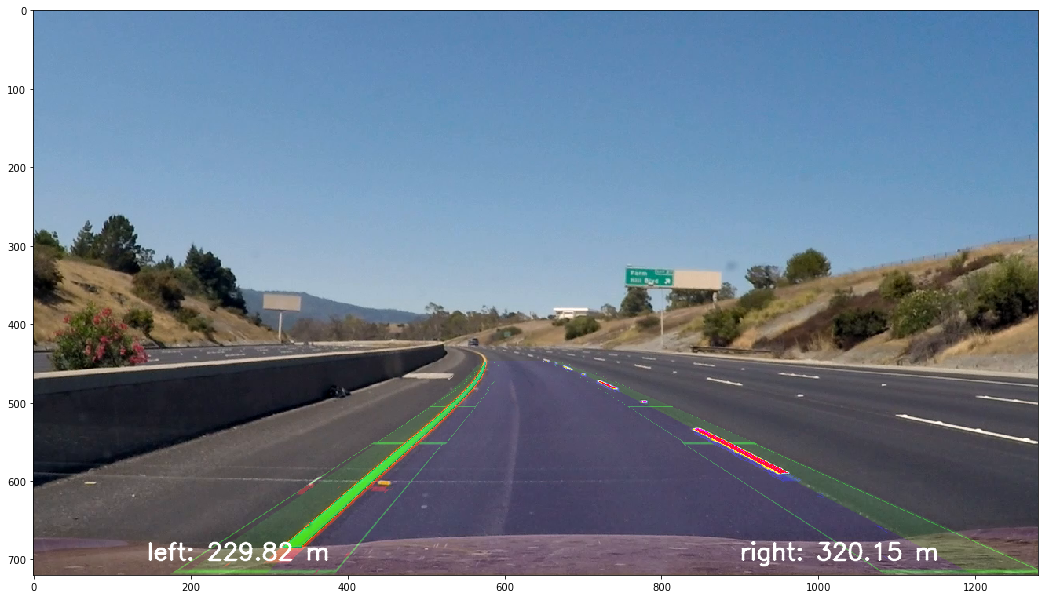

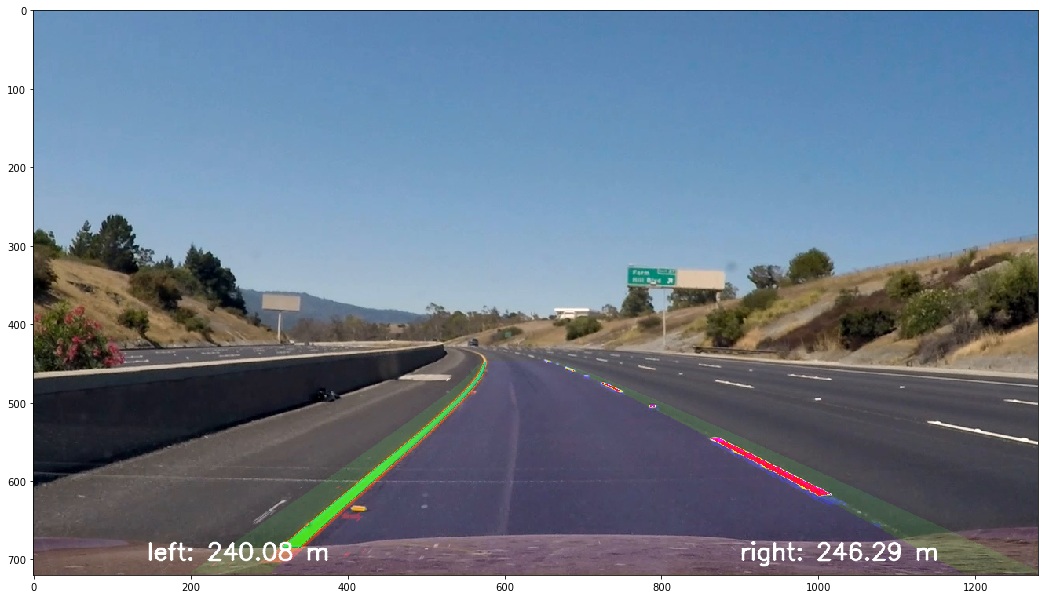

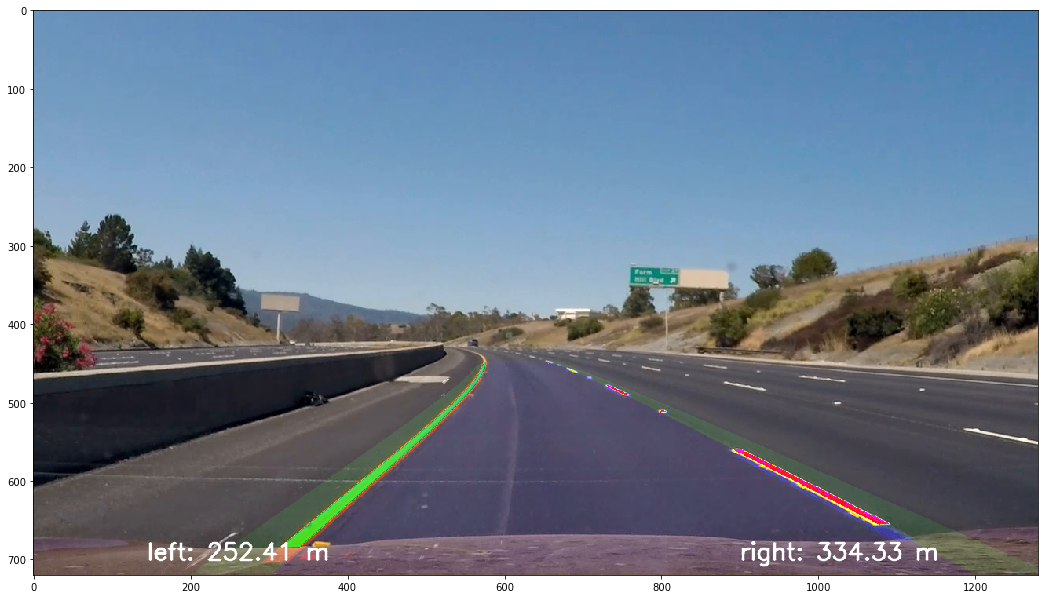

In [96]:
for frame in frames:
    
    plt.figure(figsize=(18,18))
    plt.imshow(frame)
    plt.show()